# Introduction


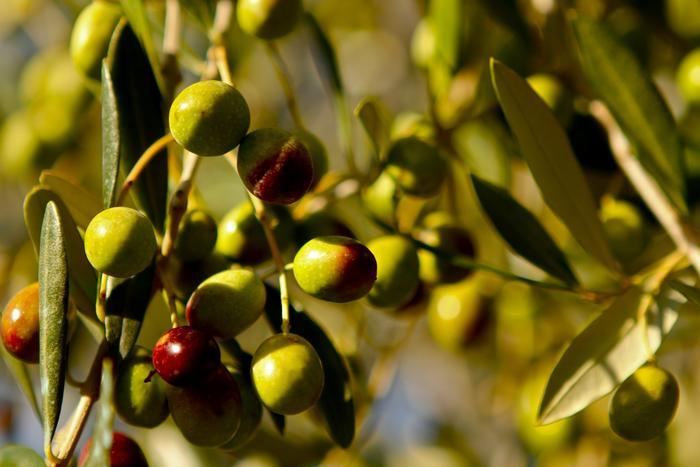

In [1]:
from IPython.display import Image
Image(filename='images/olive oils.png')

###"What I cannot create, I do not understand." - Richard Feynman

In this project I will attempt to reproduce the analysis and visualizations of the classic olive oils data-set from _"Interactive and Dynamic Graphics for Data Analysis: With Examples Using R and GGobi"_ using Python and matplotlib/seaborn. 

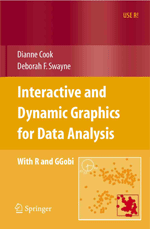

In [2]:
from IPython.display import Image
Image(filename='images/ggobi.png')

"_The Olive Oils data has eight explanatory variables (levels of fatty acids in the oils) and nine classes (areas of Italy). The goal of the analysis is to develop rules that reliably distinguish oils from the nine different areas. It is a problem of practical interest, because oil from some areas is more highly valued and unscrupulous suppliers sometimes make false claims about the origin of their oil. The content of the oils is a subject of study in its own right: Olive oil has high nutritional value, and some of its constituent fatty acids are considered to be more beneficial than others._

_In addition, this is a good dataset for students of supervised classificationbecause it contains a mix of straightforward separations, difficult separations, and unexpected finds._

_In addition, fatty acid contents vary with climate: this information is important in deciding which varieties to grow where._"

_Description: This data consists of the percentage composition of fatty acids found in the lipid fraction of Italian olive oils. The data arises from a study to determine the authenticity of an olive oil."_


-**How do we distinguish the oils from different regions and areas in Italy based on their combinations of the fatty acids?**

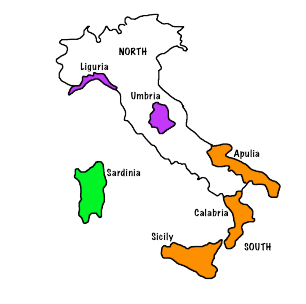

In [3]:
Image(filename='images/Italy.png')

# Libraries

In [4]:
%matplotlib inline
import brewer2mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import copy
import seaborn as sns

from matplotlib import rcParams, rcParamsDefault
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas.tools.plotting import parallel_coordinates

from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [5]:
# Custom CSS.
from IPython.core.display import HTML
def css():
    style = open("css/custom.css", "r").read()
    return HTML(style)

css()

# Loading the Data

In [6]:
df = pd.read_csv("data/olive.csv")
df.head()

,Unnamed: 0,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
0,1.North-Apulia,1,1,1075,75,226,7823,672,36,60,29
1,2.North-Apulia,1,1,1088,73,224,7709,781,31,61,29
2,3.North-Apulia,1,1,911,54,246,8113,549,31,63,29
3,4.North-Apulia,1,1,966,57,240,7952,619,50,78,35
4,5.North-Apulia,1,1,1051,67,259,7771,672,50,80,46


# Explore

In [7]:
df.shape

(572, 11)

- _Number of rows: 572_

- _Number of variables: 10_

Checking the unique regions and areas.

In [8]:
print 'regions\t', df.region.unique()
print 'areas\t', sorted(df.area.unique())

regions	[1 2 3]
areas	[1, 2, 3, 4, 5, 6, 7, 8, 9]


This verifies the information given in the description. Next, I need to make sure that each area belongs to only one region.

In [9]:
pd.crosstab(df.area, df.region)

region,1,2,3
area,,,
1,25,0,0
2,56,0,0
3,206,0,0
4,36,0,0
5,0,65,0
6,0,33,0
7,0,0,50
8,0,0,50
9,0,0,51


In [10]:
#region_groupby = df.groupby("region")
#dfrd = region_groupby.describe()
#dfrd.head(16)

# Cleaning the Data

The first column in the dataframe "Unnamed: 0" is cumbersome to deal with so I'll rename it. Its values also contain unneccessary numbers so I will strip that out also.

In [11]:
# Rename the first column.
df.rename(columns = {df.columns[0]:'areastring'}, inplace=True)

In [12]:
# Remove the numbering.
df.areastring=df.areastring.map(lambda x: x.split('.')[-1])
df.head()

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
0,North-Apulia,1,1,1075,75,226,7823,672,36,60,29
1,North-Apulia,1,1,1088,73,224,7709,781,31,61,29
2,North-Apulia,1,1,911,54,246,8113,549,31,63,29
3,North-Apulia,1,1,966,57,240,7952,619,50,78,35
4,North-Apulia,1,1,1051,67,259,7771,672,50,80,46


The values of the concentration of fatty acids should be in percentages, so that's the next change.

In [13]:
# Get a list of just the fatty acid features.
acidlist=['palmitic', 'palmitoleic', 'stearic', 'oleic', 'linoleic', 
          'linolenic', 'arachidic', 'eicosenoic']

# Make a new df for just the acids.
df1 = df[acidlist]

# Convert the acid columns to percentages.
df1 = df1.apply(lambda x: x/100.0)

# Replace the original df's acids with the new df's one.
df[acidlist] = df1

In [14]:
df.head(3)

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29
2,North-Apulia,1,1,9.11,0.54,2.46,81.13,5.49,0.31,0.63,0.29


# Exploratory Data Analysis

While the original analysis used GGobi, I'm going to use matplotlib and seaborn for plotting.

## Custom Plot Config

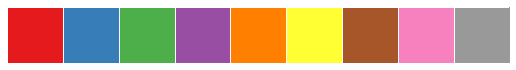

In [15]:
# Colorbrewer2 Dark2 qualitative color table.
cmap = brewer2mpl.get_map('Set1', 'Qualitative', 9)
palette = cmap.mpl_colors

sns.palplot(palette)

In [16]:
# Parameters for making plots clearer.
rcParams['figure.figsize'] = (10, 10)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['axes.grid'] = True

## Correlation of Variables

I'm going to plot the acids against each other to see if there are patterns. I'll also print out a dataframe containing the actual correlation values.

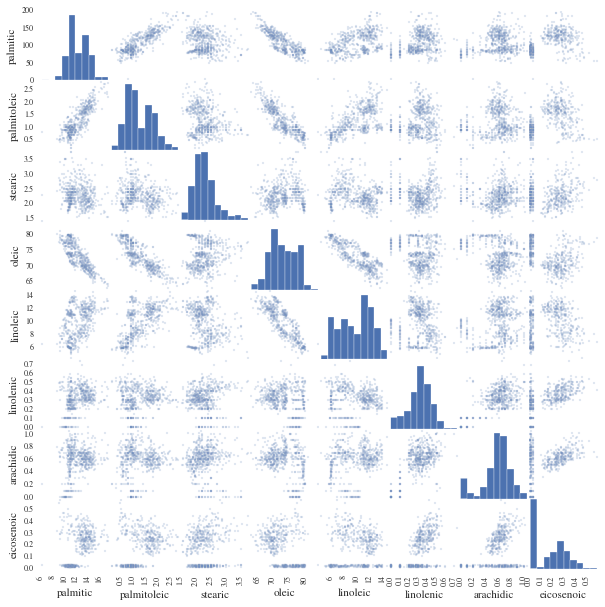

In [17]:
# Scatter matrix of just the acids.
ax = pd.tools.plotting.scatter_matrix(df1, alpha=0.2, figsize=(10, 10))    

In [18]:
df[acidlist].corr()

,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
palmitic,1.000000,0.835605,-0.170392,-0.837335,0.460684,0.319327,0.228299,0.501952
palmitoleic,0.835605,1.000000,-0.222185,-0.852438,0.621627,0.093112,0.085481,0.416350
stearic,-0.170392,-0.222185,1.000000,0.113599,-0.197817,0.018917,-0.040979,0.140377
oleic,-0.837335,-0.852438,0.113599,1.000000,-0.850318,-0.218171,-0.319962,-0.424146
linoleic,0.460684,0.621627,-0.197817,-0.850318,1.000000,-0.057439,0.210973,0.089045
linolenic,0.319327,0.093112,0.018917,-0.218171,-0.057439,1.000000,0.620236,0.578319
arachidic,0.228299,0.085481,-0.040979,-0.319962,0.210973,0.620236,1.000000,0.328663
eicosenoic,0.501952,0.416350,0.140377,-0.424146,0.089045,0.578319,0.328663,1.000000


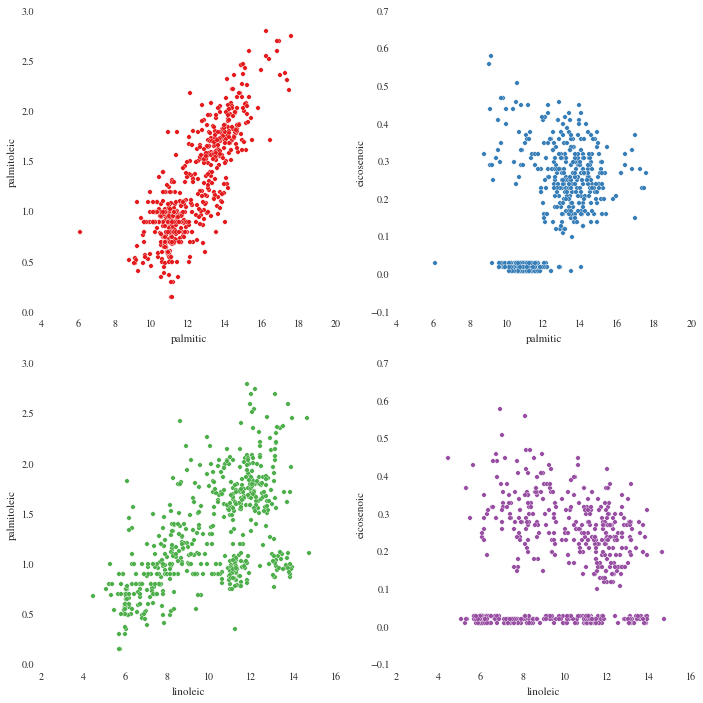

In [19]:
# List which acids to plot.
xacids=['palmitic','linoleic']
yacids=['palmitoleic','eicosenoic']

# Set up plot.
fig, ax = plt.subplots(figsize=(10,10), nrows=len(xacids), ncols=len(yacids))

# Counter.
k=0

# Plot a graph for each x, y combination.
for i, xacid in enumerate(xacids):
    for j, yacid in enumerate(yacids):
        ax[i][j].scatter(df[xacid],df[yacid], c=palette[k])
        ax[i][j].set_xlabel(xacid)
        ax[i][j].set_ylabel(yacid)
        k = k+1
        
fig.tight_layout()

There's a broad range of correlation here. For example palmitic-palmitoleic has a strong positive correlation (clustered, left-to-right slope) of 0.835, whereas linoleic-eicosenoic is randomly dispersed (no cluster, no evidence of a straight line).

## Separating the oils by area within each region

We do not start by trying to visualize or classify the oils
by area, because nine groups are too many. Instead, we divide the classification
job into a two-stage process. We start by grouping the nine areas into three
“super-classes” corresponding to a division of Italy into South, North, and
Sardinia, and we call this new variable region. In the first stage, we classify
the oils by region into three groups. In the second stage, we work with the oils
from one region at a time, building classifiers to predict area within region.

In order to investigate the relative amounts of each acid per region I will first have to aggregate the data.

In [20]:
# Create a new df that groups by region.
region_groupby = df.groupby('region')

# Make a new aggregated df for acids.
df_region = region_groupby[acidlist]

# Aggregate by the average.
df_agg_mean = df_region.aggregate(np.mean)

# Append a "_mean" to the end of each column header.
renamedict_mean={k:k+"_mean" for k in acidlist}
df_agg_mean.rename(inplace=True, columns=renamedict_mean) 

df_agg_mean.head()

,palmitic_mean,palmitoleic_mean,stearic_mean,oleic_mean,linoleic_mean,linolenic_mean,arachidic_mean,eicosenoic_mean
region,,,,,,,,
1,13.322879,1.548019,2.287740,71.000093,10.334985,0.380650,0.631176,0.273220
2,11.113469,0.967449,2.261837,72.680204,11.965306,0.270918,0.731735,0.019388
3,10.948013,0.837351,2.308013,77.930530,7.270331,0.217881,0.375762,0.019735


### Color Scheme

Next I have to map each region's number to its actual name so I can understand it better. For this I need to check what the name of areas associated with the region and check where the areas are on the map.

In [21]:
# Find out which Area each region is.
df.groupby("region").head(2)

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29
323,Inland-Sardinia,2,5,11.29,1.20,2.22,72.72,11.12,0.43,0.98,0.02
324,Inland-Sardinia,2,5,10.42,1.35,2.10,73.76,11.16,0.35,0.90,0.03
421,Umbria,3,9,10.85,0.70,1.80,79.55,6.05,0.20,0.50,0.01
422,Umbria,3,9,10.85,0.70,1.85,79.55,6.00,0.25,0.55,0.01


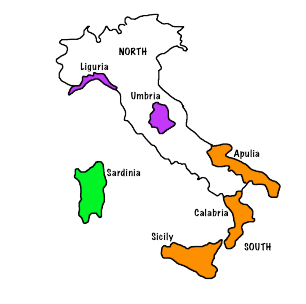

In [22]:
Image(filename='images/Italy.png')

In [23]:
# Create a map of region number: region name.
region_keys = [1,2,3]
region_names = ['South','Sardinia','North']
region_colors = ['Orange', 'Green', 'Purple']
#region_rgb = [(1.0, 0.4980, 0.0), (0.302, 0.686, 0.290), (0.596, 0.306, 0.639)]

region_map = {e[0]: [e[1], e[2]] for e in zip(region_keys, region_names, region_colors)}
region_map

{1: ['South', 'Orange'], 2: ['Sardinia', 'Green'], 3: ['North', 'Purple']}

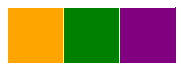

In [24]:
sns.palplot(region_colors)

### Horizontal Bar Charts

Plot the different configurations of relative acid amounts in each region.

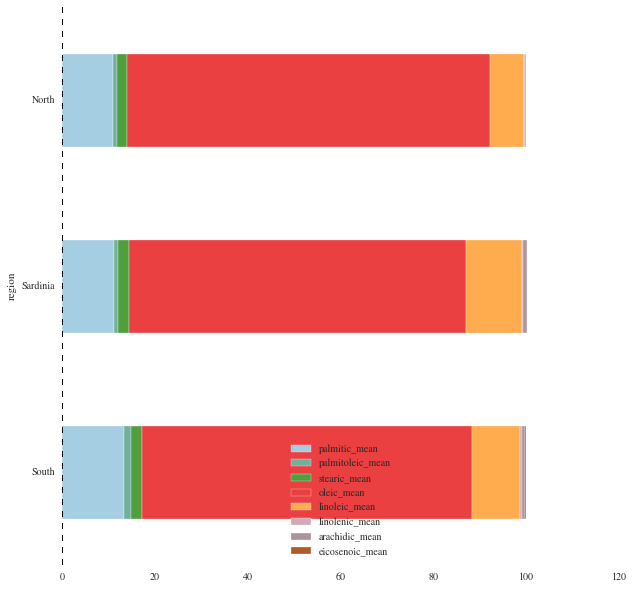

In [25]:
ax = df_agg_mean.plot(kind="barh", stacked=True, colormap="Paired")
ax.set_yticklabels(region_names);

In [26]:
df_agg_mean

,palmitic_mean,palmitoleic_mean,stearic_mean,oleic_mean,linoleic_mean,linolenic_mean,arachidic_mean,eicosenoic_mean
region,,,,,,,,
1,13.322879,1.548019,2.287740,71.000093,10.334985,0.380650,0.631176,0.273220
2,11.113469,0.967449,2.261837,72.680204,11.965306,0.270918,0.731735,0.019388
3,10.948013,0.837351,2.308013,77.930530,7.270331,0.217881,0.375762,0.019735


Oleic dominates each region, and makes it diffcult to see the proportion of the other acids. Therefore I will temporarily remove it.

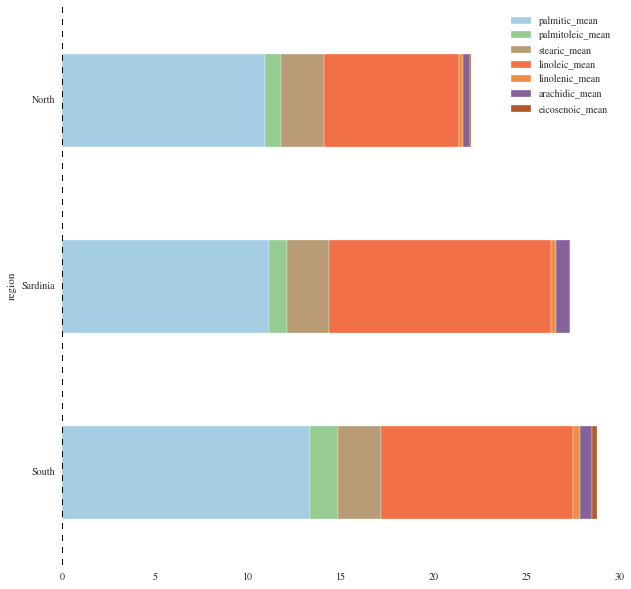

In [27]:
ax = df_agg_mean.drop("oleic_mean", axis=1).plot(kind="barh", stacked=True, colormap="Paired")
ax.set_yticklabels(region_names);

In [28]:
df_agg_mean.drop("oleic_mean", axis=1)

,palmitic_mean,palmitoleic_mean,stearic_mean,linoleic_mean,linolenic_mean,arachidic_mean,eicosenoic_mean
region,,,,,,,
1,13.322879,1.548019,2.287740,10.334985,0.380650,0.631176,0.273220
2,11.113469,0.967449,2.261837,11.965306,0.270918,0.731735,0.019388
3,10.948013,0.837351,2.308013,7.270331,0.217881,0.375762,0.019735


Note that there are is a very low percentage of eicosenoic acids in Sardinia and the North. This is something that is very useful for building a classifier so I'll investigate it further.

### Univariate Plots

We first paint the points according to region. Using univariate
plots, we look at each explanatory variable in turn, looking for separations
between pairs of regions. If we are lucky, we will find views in which there are
gaps between clusters corresponding to the classes. A gap indicates a welldefined
distinction between classes and suggests that there will be less error
in predicting future samples.

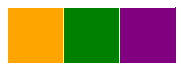

In [29]:
palette1 = ['Orange', 'Green', 'Purple']
sns.palplot(palette1)

In [30]:
def univariatePlot(df, by, region_map, offset, palette):

    """
    Creates a univariate plot with multiple facets, given a dataframe, a factor, a set 
    of labels for the regions and a color palette. Each plot contains multiple histograms.
    Offset is a hackish method to access the region_map - can be improved.
    """
    
    # Setup plot area.
    fig, axes=plt.subplots(figsize=(10,20), nrows=len(acidlist), ncols=1)

    i=0

    for ax in axes.flatten():
        # Get the name of the acid.
        acid = acidlist[i]

        # Get the pandas series.
        seriesacid = df[acid]

        # Get the min and max values.
        minmax = [seriesacid.min(), seriesacid.max()]

        # For region number and its df.
        for k, g in df.groupby(by):
            #print k, k-offset
            color = palette[k-offset]
            style = {'histtype':'stepfilled', 'alpha':0.4, 'label':region_map[k], 'color':color, 'ax':ax}
            g[acid].hist(**style)
            ax.set_xlim(minmax)
            ax.set_title(acid)
            ax.grid(False)

        # Construct legend
        ax.legend()

        i+=1

    fig.tight_layout()

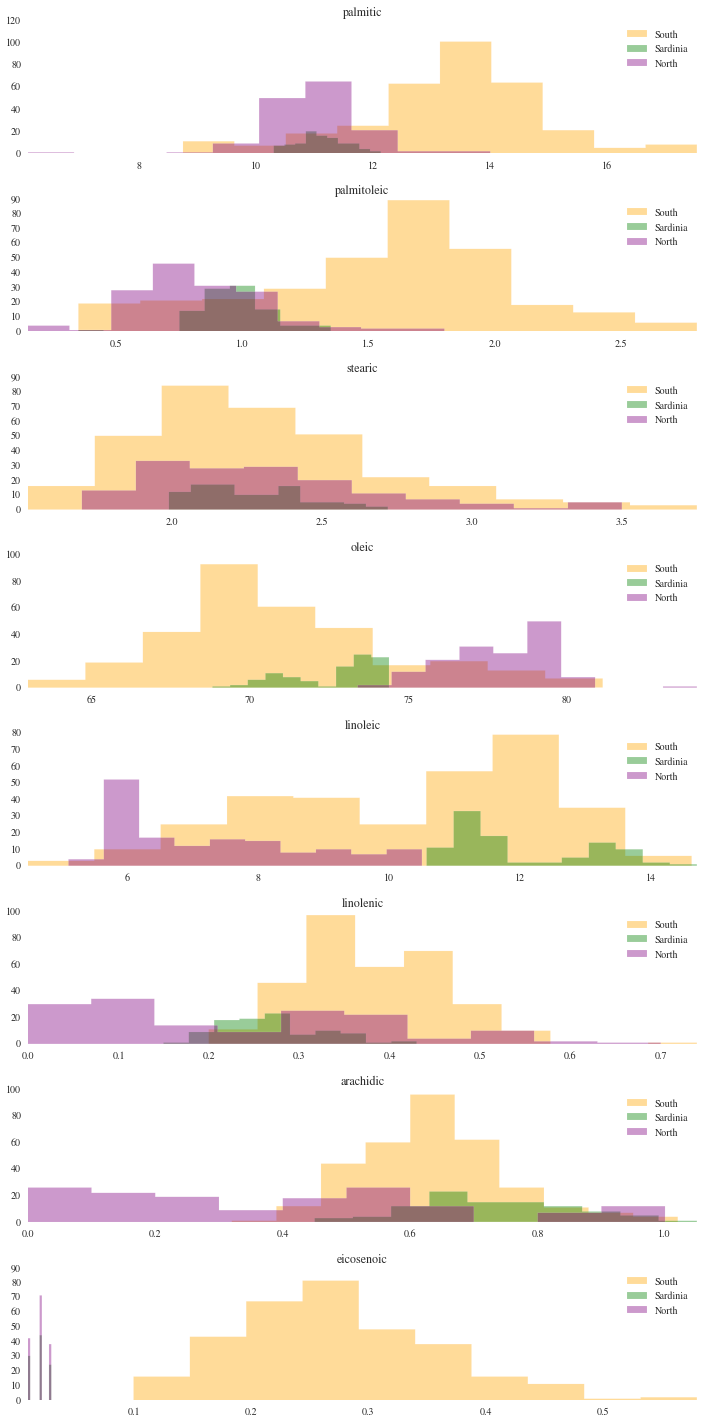

In [31]:
univariatePlot(df, 'region', region_map, 1, palette1)

The last plot shows that oils from the North and Sardinia regions contain no eicosenoic acid. This means we can cleanly separate the oils of the South (Orange) from those of the other regions using just one variable, eicosenoic.

In order to differentiate the oils from the North and Sardinia, we remove
the Southern oils from view and continue plotting one variable at a time. 

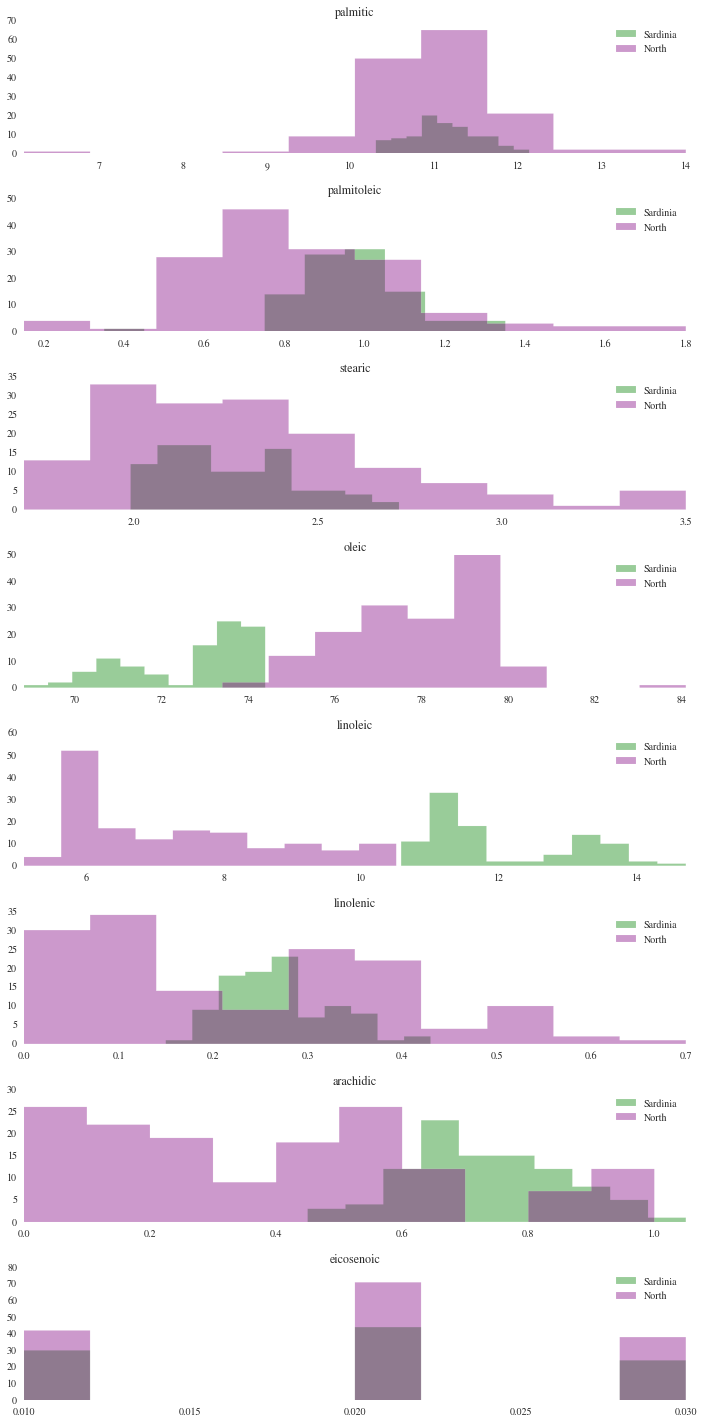

In [32]:
univariatePlot(df[df.region != 1], 'region', region_map, 1, palette1)

Several variables show differences between the oils of
the two regions, and we have plotted two of them: oleic and linoleic. Oils from
Sardinia contain lower amounts of oleic acid and higher amounts of linoleic
acid than oils from the north. The two regions are perfectly separated by
linoleic, but since there is no gap between the two groups of points, we will
keep looking.

### Bivariate Plots

If one variable is not enough to distinguish Northern oils from
Sardinian oils, perhaps we can find a pair of variables that will do the job.
Starting with oleic and linoleic, which were so promising when taken singly,
we look at pairwise scatterplots. 

In [33]:
def bivariatePlot(df, scatterx, scattery, offset, by="region", labeler={}, palette=palette1):
    
    """
    Creates a bivariate plot, given a dataframe, names of 2 columns, a factor, 
    and a set of labels for the regions.
    """
    
    #print palette
    #print labeler
    
    # Sizing for the axes.
    left, width = 0.1, 0.6
    bottom, height = 0.00, 0.6
    bottom_h = left_h = left + width + 0.02

    # Positions for the axes.
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # Instantiating the axes.
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # Divide up range(0, 1) by the number of regions. 
    # (for colors).
    cs = list(np.linspace(0, 1, len(df.groupby(by))))

    # Dicts for each region and its x, y values.
    xs = {}
    ys = {}

    # For region number and its part of the df.
    for k, g in df.groupby(by):
        #print k

        # Select the columns to plot.
        x = g[scatterx]
        y = g[scattery]

        # Store as {region1: [x1, x2...xn], region2...}.
        xs[k] = x
        ys[k] = y

        # Plot the region's data - scatter, xhist, yhist.
        color=palette[k-offset]
        #print color
        #print "label = ", labeler[k]
        axScatter.scatter(x, y, c=color, label=labeler[k], s=40, alpha=0.4);#label=labeler.get(k)[0]
        axHistx.hist(list(x), color=color, alpha=0.4)
        axHisty.hist(list(y), orientation='horizontal', color=color, alpha=0.4)
           
    # Set the scatterplot axes titles.
    axScatter.set_xlabel(scatterx.title())
    axScatter.set_ylabel(scattery.title())

    # Deleting the histogram axes titles.
    axHistx.get_xaxis().set_ticks([])
    axHistx.get_yaxis().set_ticks([])
    axHisty.get_xaxis().set_ticks([])
    axHisty.get_yaxis().set_ticks([])
    
    # Turn off the grid.
    axScatter.grid(False)

    # Add a legend.
    axScatter.legend()
    
    # Add a title
    plt.suptitle("Different Acidic Concentrations in Olives Regionally", fontsize=20)

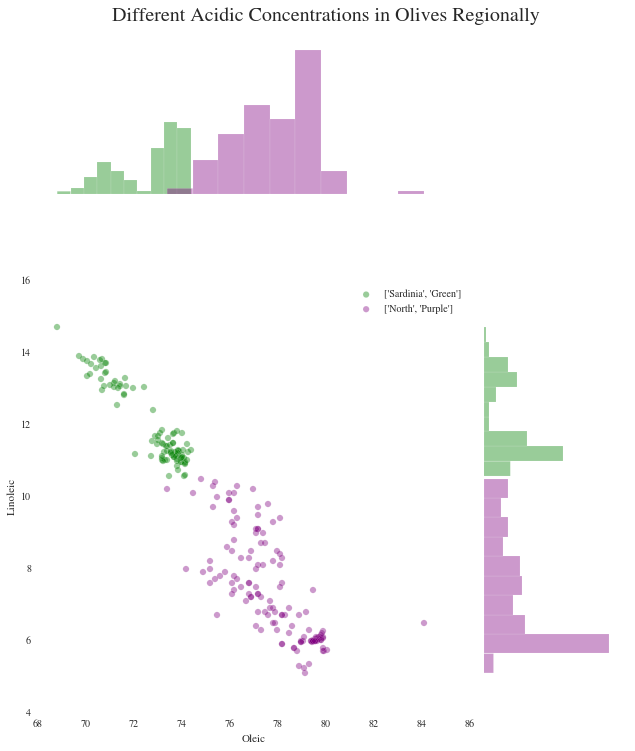

In [34]:
bivariatePlot(df[df.region != 1], "oleic", "linoleic", 1, labeler=region_map)

Unfortunately, the
combination of oleic and linoleic is no more powerful than each one was alone.
They are strongly negatively associated, and there is still not a large gap between the
two groups.
We explore other pairs of variables. 

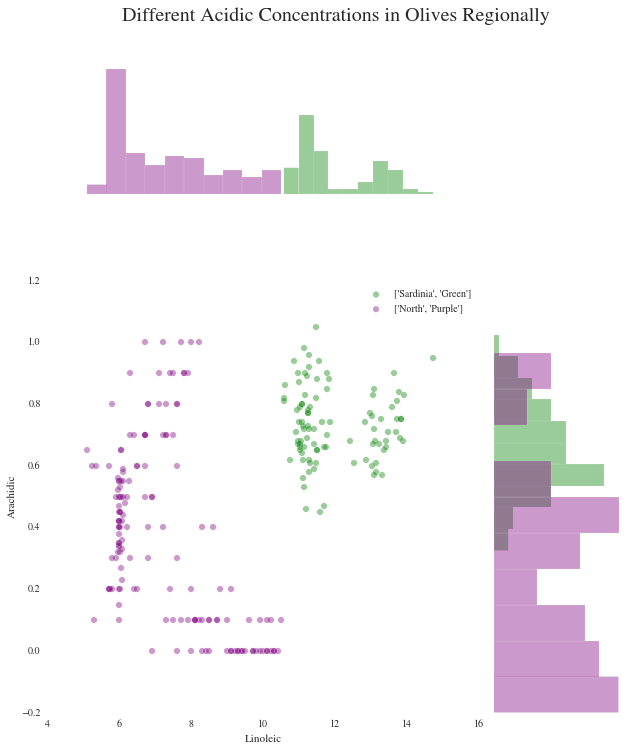

In [35]:
bivariatePlot(df[df.region != 1], "linoleic", "arachidic", 1, labeler=region_map)

Something interesting emerges from a
plot of arachidic and linoleic: There is big gap between the points of the two
regions! Arachidic alone seems to have no power to separate, but it improves
the power of linoleic. Since the gap between the two groups follows a non-linear,
almost quadratic path, we must do a bit more work to define a functional
boundary.


### Multivariate Plots

A parallel coordinate plot can also be used to select important
variables for classification. The figure below shows a parallel coordinate plot for
the Olive Oils data, where the three colors represent the three large regions.


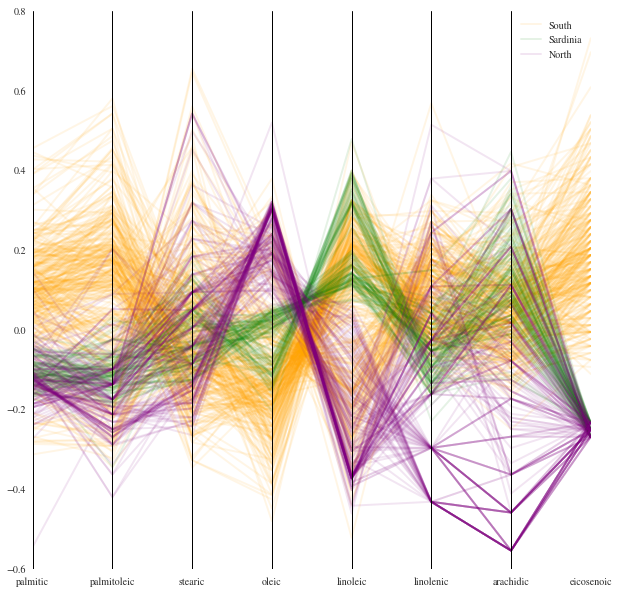

In [36]:
# Drop unneeded cols.
dfna = df.drop(['areastring', 'area'], axis=1)

# Normalize the acid levels.
dfna_norm = (dfna - dfna.mean()) / (dfna.max() - dfna.min())

# Map region to real name.
dfna_norm['region'] = df['region'].map(lambda x: region_map[x][0])

parallel_coordinates(dfna_norm, 'region', alpha=0.1, color=palette1)

#palette1[k-1]

As we found earlier, eicosenoic is useful for separating Southern oils (orange,
the color drawn first) from the others. In addition, Southern oils have higher
values on palmitic and palmitoleic and low values on oleic. Northern oils have
high values of oleic and low values of linoleic relative to Sardinian oils.
Parallel coordinate plots are not as good as tours for visualizing the shape
of the clusters corresponding to classes and the shape of the boundaries between
them, but they are attractive because they can hold so many variables
at once and still be clearly labeled.

## Separating the oils by area within each region

It is now clear that the oils from the three large regions can be distinguished
by their fatty acid composition. For the second stage of the classification task,
we explore one region at a time, looking for separations among the oils of each
area.We plan to separate them visually just as we did in the preceding section,
by starting with univariate plots and adding dimensions using bivariate and
multivariate plots if necessary.

In [37]:
df.head(2)

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29


In [38]:
area_keys = list(df.area.unique())
area_keys

[1, 2, 3, 4, 5, 6, 9, 7, 8]

In [39]:
# Create a map of region number: region name.
area_keys = list(df.area.unique())
area_names = list(df.areastring.unique())

area_map = {e[0]: [e[1]] for e in zip(area_keys, area_names)}
area_map

{1: ['North-Apulia'],
 2: ['Calabria'],
 3: ['South-Apulia'],
 4: ['Sicily'],
 5: ['Inland-Sardinia'],
 6: ['Coast-Sardinia'],
 7: ['East-Liguria'],
 8: ['West-Liguria'],
 9: ['Umbria']}

## Northern Italy

In [40]:
df_north = df[df.region == 3]
df_north.head(2)

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
421,Umbria,3,9,10.85,0.7,1.80,79.55,6.05,0.20,0.50,0.01
422,Umbria,3,9,10.85,0.7,1.85,79.55,6.00,0.25,0.55,0.01


In [41]:
north_map = df_north.areastring.unique()

### Univariate Plots

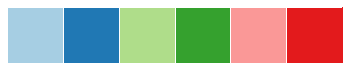

In [42]:
palette2 = sns.color_palette("Paired")#['Red', 'Green', 'Blue', 'Yellow']
sns.palplot(palette2)

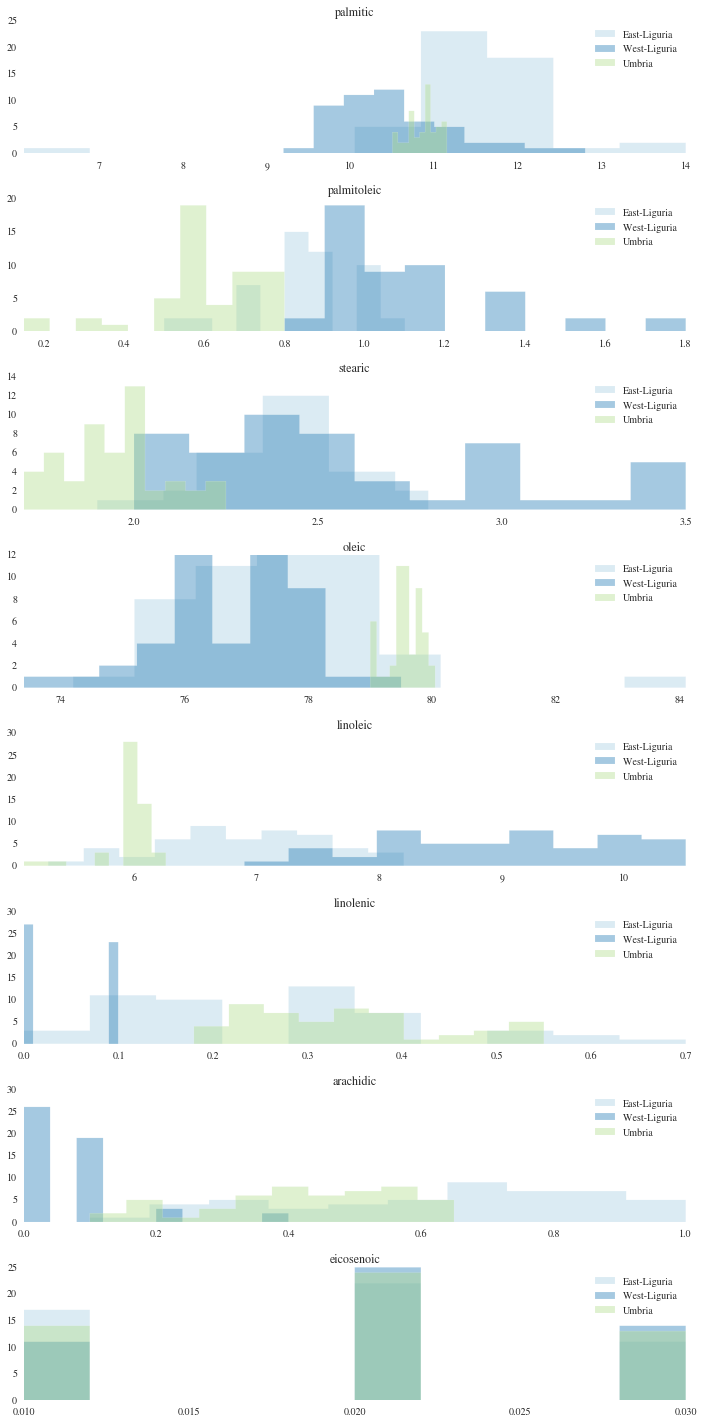

In [43]:
univariatePlot(df_north, 'area', area_map, 7, palette2)

The univariate plots show no clear separations of oils by area, although several
variables are correlated with area. For example, oils from West Liguria have
higher linoleic acid content than those from other two areas.

### Bivariate Plots

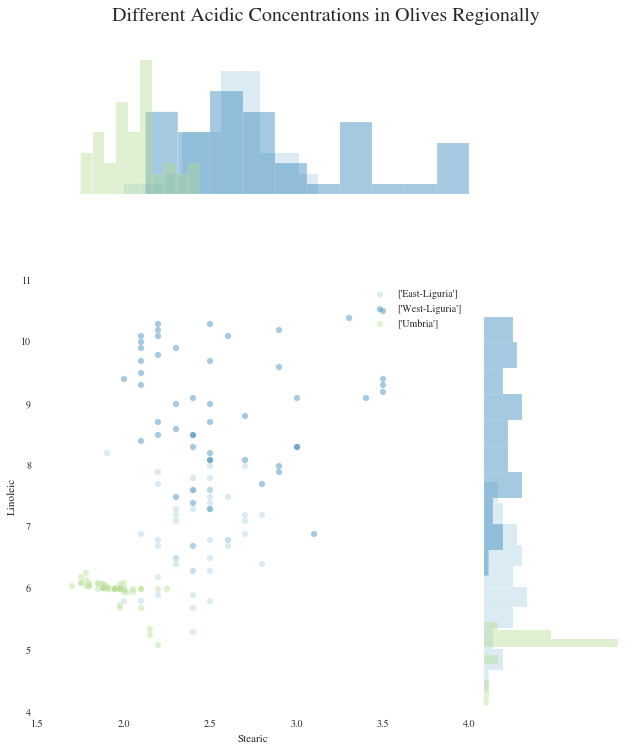

In [44]:
bivariatePlot(df_north, "stearic", "linoleic", 7, by="area", labeler=area_map, palette=palette2)

The bivariate plots, too, fail to show clear separations by area, but two
variables, stearic and linoleic, look useful. Oils from West
Liguria have the highest linoleic and stearic acid content, and oils from Umbria
have the lowest linoleic and stearic acid content.

## Sardinia

In [45]:
df_sardinia = df[df.region == 2]
df_sardinia.head(2)

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
323,Inland-Sardinia,2,5,11.29,1.20,2.22,72.72,11.12,0.43,0.98,0.02
324,Inland-Sardinia,2,5,10.42,1.35,2.10,73.76,11.16,0.35,0.90,0.03


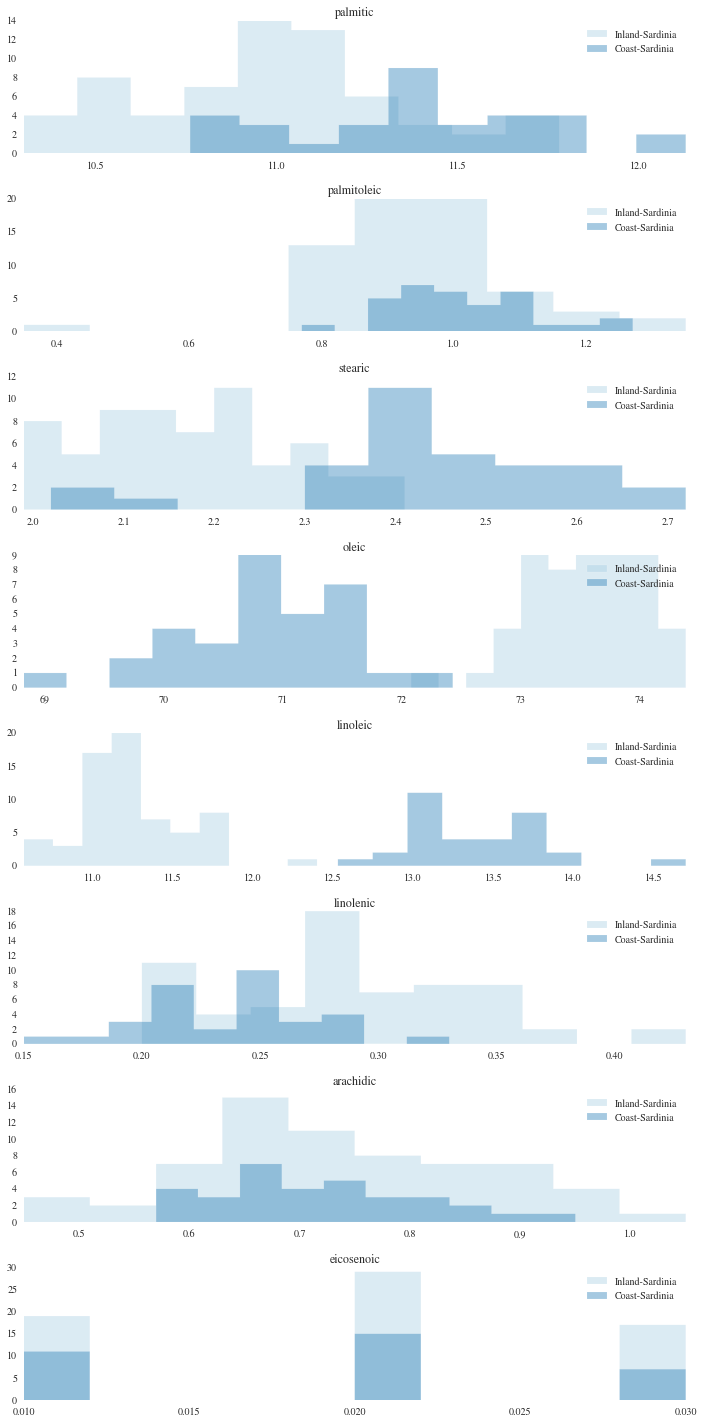

In [46]:
univariatePlot(df_sardinia, 'area', area_map, 5, palette2)

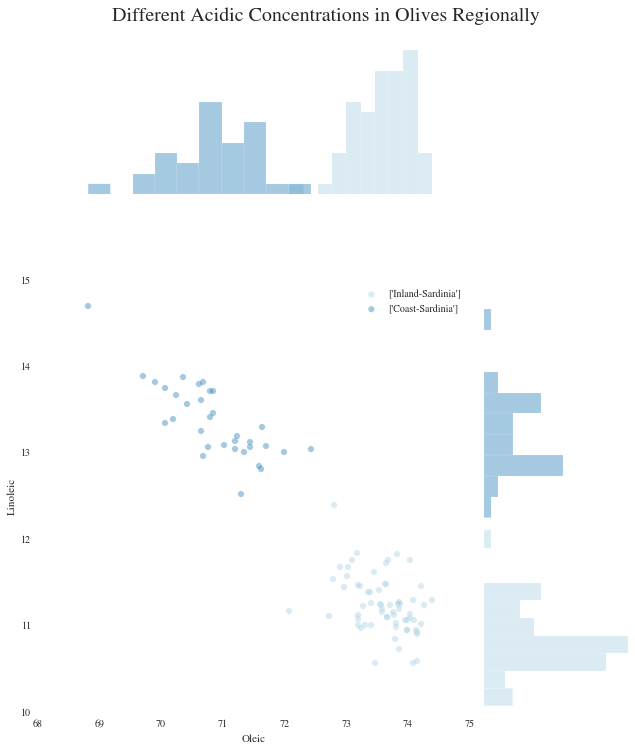

In [47]:
bivariatePlot(df_sardinia, "oleic", "linoleic", 5, by="area", labeler=area_map, palette=palette2)

Sardinia is composed of two areas, Coastal and Inland, which can be separated into distinct clusters when looking at oleic and linoleic levels. 

## Southern Italy

In [ ]:
df_southern = df[df.region == 1]
df_southern.head(2)

,areastring,region,area,palmitic,palmitoleic,stearic,oleic,linoleic,linolenic,arachidic,eicosenoic
0,North-Apulia,1,1,10.75,0.75,2.26,78.23,6.72,0.36,0.60,0.29
1,North-Apulia,1,1,10.88,0.73,2.24,77.09,7.81,0.31,0.61,0.29


In [ ]:
univariatePlot(df_southern, 'area', area_map, 4, palette2)

In [ ]:
bivariatePlot(df_southern, "palmitoleic", "palmitic", 4, by="area", labeler=area_map, palette=palette2)

In this data, four areas are grouped into the region “South.”
These are North Apulia, South Apulia, Calabria, and Sicily. The prospect of finding visual separations between these four areas looks
dismal. In a scatterplot of palmitoleic and palmitic, there
is a big gap between North Apulia (low on both variables) and South Apulia
(high on both variables), with Calabria in the middle. The troublemaker is
Sicily: The cluster of oils from Sicily overlaps those of the other three areas.

## Taking Stock

The Olive Oils have dramatically different fatty acid composition depending on
geographic region. The three geographic regions, created by aggregating the
areas into North, South and Sardinia, are well separated based on eicosenoic,
linoleic, and arachidic.

The oils from the North are mostly separable from each other by area,
using all variables. The oils from the inland and coastal regions of Sardinia
have different amounts of oleic and linoleic acids.

The oils from three areas in the South are almost separable, but the oils
from Sicily can not be separated. Why are these oils indistinguishable from
the oils of the other areas in the South? Is there a problem with the quality
of these samples?

# Numerical Methods

In this section, we show how classification algorithms can be supported and
enhanced by graphical methods. Graphics should be used before modeling,
to make sure the data conforms to the assumptions of the model, and they
are equally useful after modeling, to assess the fit of the model, study the
failures, and compare the results of different models. Without graphics, it is
easy to apply an algorithm inappropriately and to achieve results that seem
convincing but have little or no meaning.

#Support Vector Machines

A support vector machine (SVM) (Vapnik 1999) is a binary classification
method. An SVM looks for gaps between clusters in the data, based on the
extreme observations in each class. In this sense it mirrors the graphical approach
described at the start of this notebook, in which we searched for gaps
between groups.

We use the svm function in Scikit-Learn package of python, to classify  the oils of the four areas in the Southern region.SVM is a
binary classifier, but this algorithm overcomes that limitation by comparing
classes in pairs, fitting six separate classifiers, and then using a voting scheme
to make predictions. To fit the SVM we also need to specify a kernel, or rely
on the internal tuning tools of the algorithm to choose this for us.

## Predicting region using all acids

In [ ]:
df.head(2)

In [ ]:
df_modelling = df.drop(['area', 'areastring'], axis=1)
df_modelling.head(1)

In [ ]:
# Set the target and drop it from the new df.
target = df_modelling['region']
data = df_modelling.drop("region", axis=1)

# Set the proportion of data saved for testing purposes.
proportion = 0.3

# Split the data.
training_data, test_data, training_target, test_target = train_test_split(data, 
                                                                          target, 
                                                                          random_state=0, 
                                                                          test_size=proportion)

In [ ]:
# Initialize a SVM classifier and fit it to the training data.
clf = SVC()
clf = clf.fit(training_data, training_target)

# Use the model to predict the testing set's labels.
clf_predictions = clf.predict(test_data)

In [ ]:
# Compare the predictions with the actual labels.
accuracy_score(test_target, clf_predictions)

In [ ]:
confusion_matrix(clf_predictions, test_target)

## Examining boundaries

For some classification problems, it is possible to get a good picture of the
boundary between two classes. With SVM classifiers the boundary
is described by the equation of a hyperplane. In this section we will predict the region of the oils using just two acids in order to visualize hyperplanes of different kernels.

In [ ]:
df_modelling = df.drop(['area', 'areastring'], axis=1)

two_acids = ["linoleic", "eicosenoic"]
df_modelling = df_modelling[['region', two_acids[0], two_acids[1]]]
df_modelling.head()

In [ ]:
# Set the target and drop it from the new df.
target = df_modelling['region']
data = df_modelling.drop("region", axis=1)

# Set the proportion of data saved for testing purposes.
proportion = 0.3

# Split the data.
training_data, test_data, training_target, test_target = train_test_split(data, 
                                                                          target, 
                                                                          random_state=0, 
                                                                          test_size=proportion)

In [ ]:
# Initialize a SVM classifier and fit it to the training data.
clf = SVC()
clf = clf.fit(training_data, training_target)

# Use the model to predict the testing set's labels.
clf_predictions = clf.predict(test_data)

In [ ]:
# Compare the predictions with the actual labels.
accuracy_score(test_target, clf_predictions)

In [ ]:
confusion_matrix(clf_predictions, test_target)

As observed earlier linoleic and eicosenoic are great predictors for where an oil comes from. In fact they  have the same accuracy as using every acid available but are prone to slightly different classification errors.

In [ ]:
def SVMplot(X, y, two_acids):
    
    """
    Creates a bivariate plot of the data and a color plot to display the SMV plane.
    Takes training data, training target, and the two variables of interest.
    """
    
    # Step size in the mesh.
    h = .02  

    # SVM regularization parameter.
    C = 1.0  
    
    # Initialize several SVM classifiers and fit them to the training data.
    svc = SVC(kernel='linear', C=C).fit(X, y)
    lin_svc = LinearSVC(C=C).fit(X, y)
    rbf_svc = SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
    poly_svc = SVC(kernel='poly', degree=3, C=C).fit(X, y)
    
    # Create a mesh to plot in.
    x_min, x_max = X[:, 0].min() - .8, X[:, 0].max() + .8
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Title for the plots
    titles = ['SVC with linear kernel',
              'LinearSVC (linear kernel)',
              'SVC with RBF kernel',
              'SVC with polynomial (degree 3) kernel']


    for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
        
        clf_predictions = clf.predict(test_data)
        
        # Compare the predictions with the actual labels.
        print "{}%".format(accuracy_score(test_target, clf_predictions)*100)
        
        print confusion_matrix(clf_predictions, test_target), "\n"
        
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        plt.subplot(2, 2, i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot.
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

        # Plot also the training points.
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.scatter(test_data[:, 0], test_data[:, 1], c=test_target, cmap=plt.cm.Paired)
        plt.xlabel(two_acids[0])
        plt.ylabel(two_acids[1])

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        plt.axis('tight')
        plt.xticks(())
        plt.yticks(())
        plt.title(titles[i])

    plt.show()

In [ ]:
SVMplot(training_data, training_target, two_acids)

The linear SVMs do a very nice job with this difficult classification and reinforces our earlier eyeballing of the data. The
accuracy is almost perfect on three classes, and the misclassifications are quite
reasonable mistakes, being points that are on the extreme edges of their clusters.

## Predicting area

In [ ]:
df_modelling = df.drop(['region', 'areastring'], axis=1)
df_modelling.head(1)

In [ ]:
# Set the target and drop it from the new df.
target = df_modelling['area']
data = df_modelling.drop("area", axis=1)

# Set the proportion of data saved for testing purposes.
proportion = 0.3

# Split the data.
training_data, test_data, training_target, test_target = train_test_split(data, 
                                                                          target, 
                                                                          random_state=0, 
                                                                          test_size=proportion)

In [ ]:
# Initialize a SVM classifier and fit it to the training data.
clf = SVC()
clf = clf.fit(training_data, training_target)

# Use the model to predict the testing set's labels.
clf_predictions = clf.predict(test_data)

In [ ]:
# Compare the predictions with the actual labels.
accuracy_score(test_target, clf_predictions)

In [ ]:
confusion_matrix(clf_predictions, test_target)

## Predicting area within the southern region using just two acids

The SVM achieves a good accuracy of 90% for classifying all areas. However, now we'll delve further into the difficult case of sicily in the southern region as mentioned earlier.

In [ ]:
df_modelling = df_southern.drop(['region', 'areastring'], axis=1)
two_acids = ["linoleic", "eicosenoic"]
df_modelling = df_modelling[['area', two_acids[0], two_acids[1]]]
df_modelling.head()

In [ ]:
# Set the target and drop it from the new df.
target = df_modelling['area']
data = df_modelling.drop("area", axis=1)

# Set the proportion of data saved for testing purposes.
proportion = 0.3

# Split the data.
training_data, test_data, training_target, test_target = train_test_split(data, 
                                                                          target, 
                                                                          random_state=0, 
                                                                          test_size=proportion)

In [ ]:
SVMplot(training_data, training_target, two_acids)

In [ ]:
bivariatePlot(df_southern, two_acids[0], two_acids[1], 4, by="area", labeler=area_map, palette=palette2)

Perfect separation between the classes does not occur. Sicily really complicates matters and drastically affects the different hyperplanes in each SVM. This in turn negatively affects the accuracy of the model by up to 15%.

# Recap

These partial analyses of the Italian Olive Oils demonstrate that it is possible
to get a good mental image of cluster structure in relation to class identity
in high-dimensional space. This is possible with many multivariate datasets.
Having a good mental image of the class structure can help with many tasks
in a classification analysis: choosing an appropriate classifier, validating (or
rejecting!) the results of a classification, and simplifying the final model.

The Olive Oils data has nine classes. Jumping straight into classifying
the oils into nine classes by area would have led to dismal results. Instead,
we aggregated areas to form a new class variable, region, with only three
levels. That allowed us to start with the simpler problem of classifying the oils
into only three classes, and then use the hierarchical nature of the classes to
structure the analysis. This strategy can often be used to simplify classification
problems with many classes: divide and conquer.

Graphics can be used to check whether the variance–covariance structure is
consistent with a multivariate normal model for classical classifiers, or whether
the separations between groups fall along single variable axes so that trees
can be used effectively. Linked plots allow us to examine the rich diagnostics
provided by random forests and to explore misclassifications exposed by the
misclassification table. We can see how well the support vectors mark the
separation between classes. It can be surprising to examine the boundary
generated by a classifier, even when it has an extremely low error rate.
For the Olive Oils, we saw that the data has a story to tell: The olive oils of
Italy are remarkably different in composition based on geographic boundaries.
There is something fishy about the Sicilian oils in this data, and the most
plausible story is that the Sicilian oils used borrowed olives from neighboring
areas. This is interesting! Data analysis is detective work.